## IST 691 Final Project Notebook
#### Note: Utilize GPU Runtime for Faster Model Compilation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# INITIAL IMPORTS

import os
import random
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import clone_model
from keras.models import load_model
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
### Citation : https://www.kaggle.com/code/umaralikaggle12/brain-tumor-detection

input_size = (256,256)

test_data= "/content/drive/MyDrive/Brain_Tumor_Detection/Testing"
train_data= "/content/drive/MyDrive/Brain_Tumor_Detection/Training"

train_ds= tf.keras.utils.image_dataset_from_directory(
    train_data,
    image_size= input_size,
    batch_size=16,
    seed=123,
)
val_ds= tf.keras.utils.image_dataset_from_directory(
    test_data,
    image_size=input_size,
    batch_size=16,
    seed=123,
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [5]:
class_names = train_ds.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

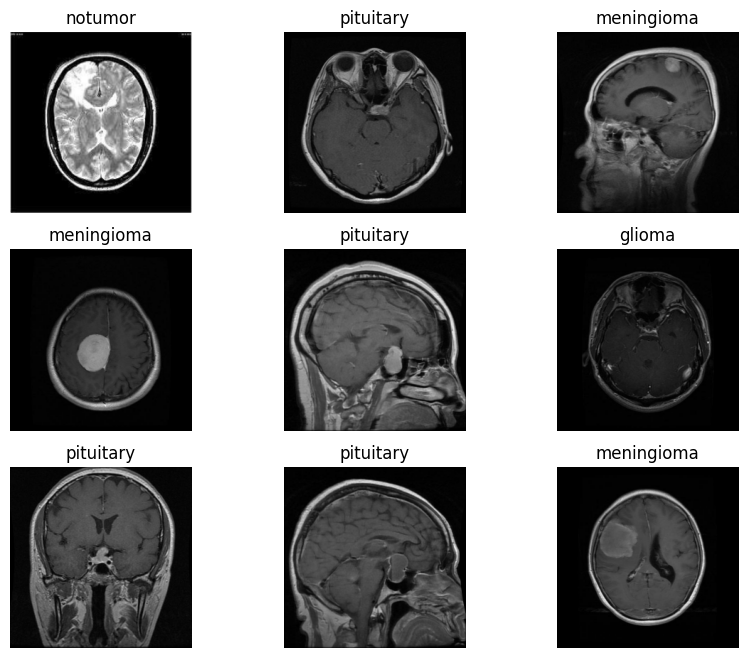

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
for images,labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [ ]:
from PIL import Image
import os


def show_image(tumor_class, image_name):

  image_directory = f"{train_data}/{tumor_class}" # Image Path
  image_path = os.path.join(image_directory, image_name)

  try:
    # Open the image using Pillow
    img = Image.open(image_path)

    # Display the image using Matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide axes for a cleaner view
    plt.title(tumor_class)
    plt.show()

  except FileNotFoundError:
    print(f"Error: Image file not found at '{image_path}'")
  except Exception as e:
    print(f"An error occurred: {e}")



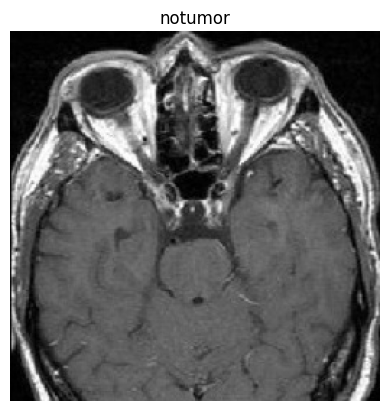

In [ ]:
show_image('notumor', 'Tr-noTr_0000.jpg')

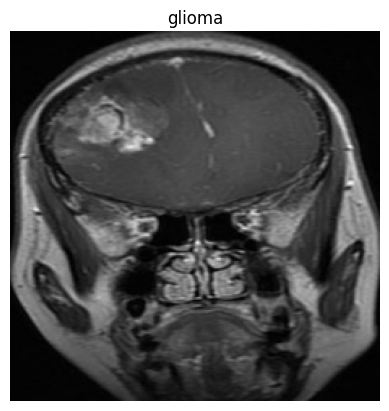

In [ ]:
show_image('glioma', 'Tr-glTr_0000.jpg')

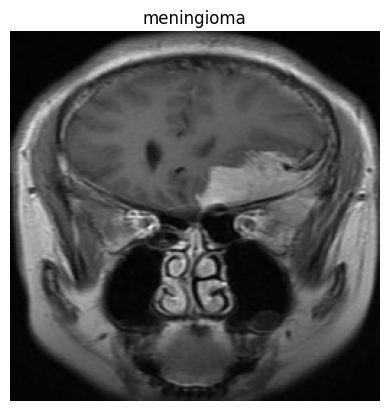

In [ ]:
show_image('meningioma', 'Tr-meTr_0000.jpg')

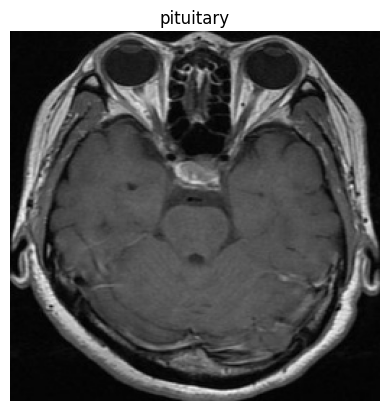

In [ ]:
show_image('pituitary', 'Tr-piTr_0000.jpg')

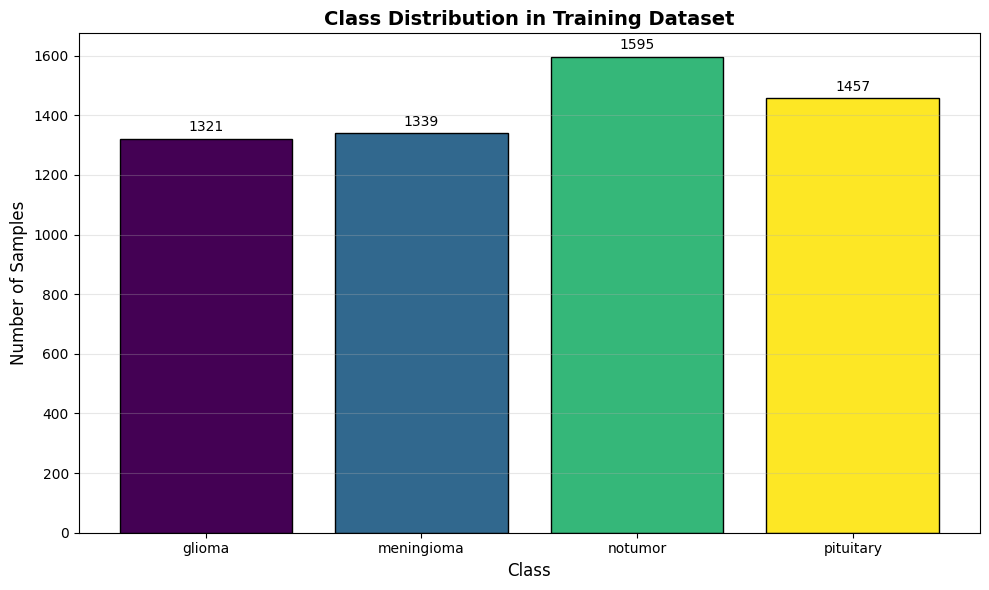

In [ ]:
# Extract all labels from your Keras dataset
labels = np.concatenate([y for x, y in train_ds], axis=0)

# If labels are one-hot encoded, convert to class indices
if len(labels.shape) > 1:
    labels = np.argmax(labels, axis=1)

# Count occurrences of each class
unique_classes, counts = np.unique(labels, return_counts=True)

# Create the plot
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
plt.bar(unique_classes, counts, color=colors, edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in Training Dataset', fontsize=14, fontweight='bold')
plt.xticks(unique_classes, train_ds.class_names)
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of bars
for i, (class_id, count) in enumerate(zip(unique_classes, counts)):
    plt.text(class_id, count + max(counts)*0.01, str(count),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

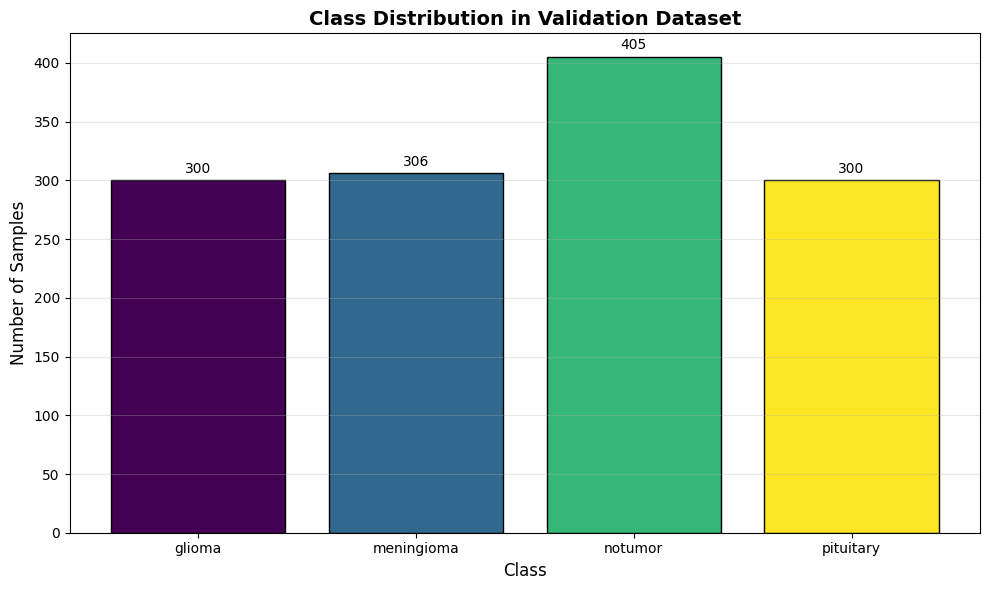

In [ ]:
# Extract all labels from your Keras dataset
labels = np.concatenate([y for x, y in val_ds], axis=0)

# If labels are one-hot encoded, convert to class indices
if len(labels.shape) > 1:
    labels = np.argmax(labels, axis=1)

# Count occurrences of each class
unique_classes, counts = np.unique(labels, return_counts=True)

# Create the plot
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
plt.bar(unique_classes, counts, color=colors, edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in Validation Dataset', fontsize=14, fontweight='bold')
plt.xticks(unique_classes, val_ds.class_names)
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of bars
for i, (class_id, count) in enumerate(zip(unique_classes, counts)):
    plt.text(class_id, count + max(counts)*0.01, str(count),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Add these imports at the top
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# After your existing dataset loading code, add this:

# Data augmentation and preprocessing
def create_data_pipeline():
    # Data augmentation for training
    data_augmentation = tf.keras.Sequential([
        # randomly flip each image horizontally
        layers.RandomFlip('horizontal'),
        # changes how clear the image comes out
        layers.RandomSharpness(factor = 0.2),
        layers.RandomSaturation(factor=0.3),
        layers.RandomSaturation(factor=0.7)
    ])

    # Preprocessing function for EfficientNet
    def preprocess_train(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.keras.applications.efficientnet.preprocess_input(image)
        image = data_augmentation(image)
        return image, label

    def preprocess_val(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.keras.applications.efficientnet.preprocess_input(image)
        return image, label

    return preprocess_train, preprocess_val

# Create the EfficientNet model
def create_efficientnet_model(num_classes=4, input_shape=(256, 256, 3)):
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Add custom classification head
    inputs = tf.keras.Input(shape=input_shape)


    x = base_model(inputs)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Add dropout for regularization
    x = layers.Dropout(0.2)(x)

    # Additional dense layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model, base_model

# Compile the model
def compile_model(model, learning_rate=0.001):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:

# Training function with fine-tuning
def train_with_finetuning(train_ds, val_ds, num_classes=4, epochs=20, monitor_metric = 'val_accuracy'):
    # Create preprocessing functions
    preprocess_train, preprocess_val = create_data_pipeline()

    # Apply preprocessing to datasets
    train_ds_processed = train_ds.map(preprocess_train,
                                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_processed = val_ds.map(preprocess_val,
                                 num_parallel_calls=tf.data.AUTOTUNE)

    # Prefetch for performance
    train_ds_processed = train_ds_processed.prefetch(tf.data.AUTOTUNE)
    val_ds_processed = val_ds_processed.prefetch(tf.data.AUTOTUNE)

    # Create model
    model, base_model = create_efficientnet_model(num_classes)
    #model = compile_model(model, learning_rate=0.001)

    # Callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor=monitor_metric,
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor=monitor_metric,
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
    ]

    #print("=== Phase 1: Training with frozen base model ===")
    # First: train only the classification head
    #history1 = model.fit(
    #    train_ds_processed,
     #   epochs=min(10, epochs//2),  # First phase - shorter
    #    validation_data=val_ds_processed,
    #    callbacks=callbacks,
   #     verbose=1
   # )

    print("=== Fine-tuning entire model ===")


    # Fine-tune from this layer onwards
    fine_tune_at = len(base_model.layers) // 3

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Continue training
    history = model.fit(
        train_ds_processed,
        epochs=epochs,
        #initial_epoch=len(history1.epoch),
        validation_data=val_ds_processed,
        callbacks=callbacks,
        verbose=1
    )

    # Combine histories
    total_history = {}
    for key in history.history.keys():
        total_history[key] = history.history[key]

    return model, total_history

# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history['accuracy'], label='Training Accuracy')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history['loss'], label='Training Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Evaluate and show predictions
def evaluate_model(model, val_ds, class_names):
    # Evaluate on validation set
    val_ds_processed = val_ds.map(
        lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(tf.cast(x, tf.float32)), y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    # Get predictions
    print("\n=== Making Predictions ===")
    for images, labels in val_ds_processed.take(1):
        predictions = model.predict(images)
        predicted_classes = tf.argmax(predictions, axis=1)

        # Display some predictions
        plt.figure(figsize=(12, 8))
        for i in range(min(9, len(images))):
            plt.subplot(3, 3, i + 1)
            # De-preprocess for display
            img = images[i].numpy()
            img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
            plt.imshow(img)
            true_label = class_names[labels[i]]
            pred_label = class_names[predicted_classes[i]]
            confidence = predictions[i][predicted_classes[i]]
            color = 'green' if true_label == pred_label else 'red'
            plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                     color=color, fontsize=8)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        break


Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Starting training...
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
=== Fine-tuning entire model ===
Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 105s 120ms/step - accuracy: 0.8207 - loss: 0.5668 - val_accuracy: 0.9657 - val_loss: 0.1133 - learning_rate: 0.0010
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.9330 - loss: 0.2029 - val_accuracy: 0.9786 - val_loss: 0.0606 - learning_rate: 0.0010
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9507 - loss: 0.1495 - val_accuracy: 0.9802 - val_loss: 0.0661 - learning_rate: 0.0010
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9739 - loss: 0.0959 - val_accuracy: 0.9703 - val_loss: 0.0849 - learning_rate: 0.0010
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9717 - loss: 0.0882 - val_accuracy: 0.9916 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accur

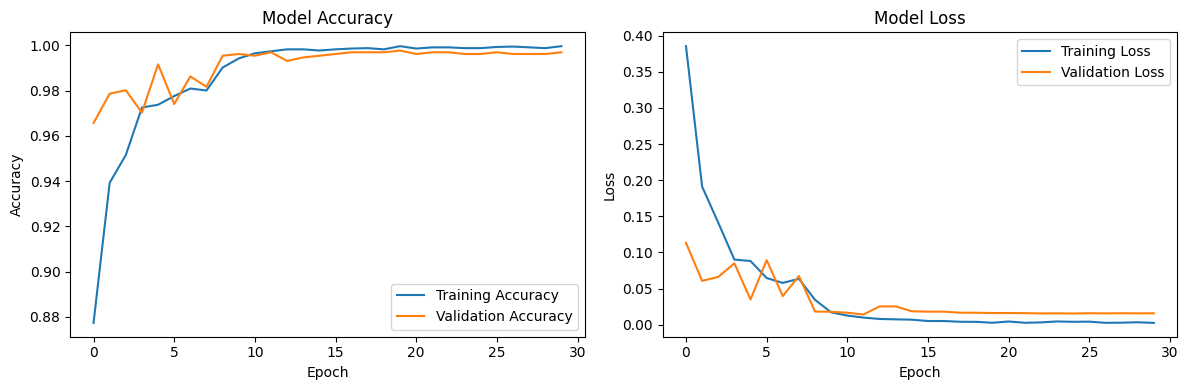


=== Making Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


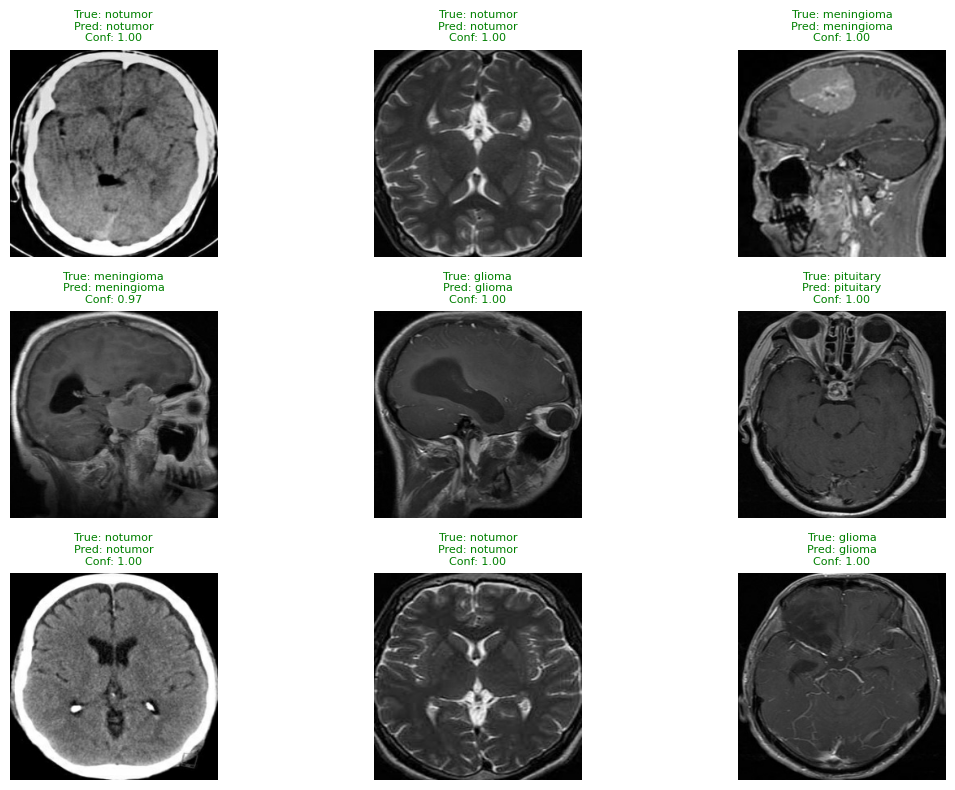

Model saved as 'brain_tumor_efficientnet1.keras'

Final Training Accuracy: 0.9996
Final Validation Accuracy: 0.9977


In [ ]:
import random
import os

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


# Main execution
if __name__ == "__main__":
    # Use your existing datasets
    print("Class names:", class_names)

    # Train the model
    print("Starting training...")
    model, history = train_with_finetuning(train_ds, val_ds, num_classes=4, epochs=50)

    # Plot training history
    plot_training_history(history)

    # Evaluate and show predictions
    evaluate_model(model, val_ds, class_names)

    # Save the model
    #model.save('brain_tumor_efficientnet1.keras')
    print("Model saved as 'brain_tumor_efficientnet1.keras'")

    # Print final metrics
    best_idx = np.argmax(history['val_accuracy'])
    final_train_acc = history['accuracy'][best_idx]
    final_val_acc = history['val_accuracy'][best_idx]
    print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Training Accuracy: 0.9996
Final Validation Accuracy: 0.9977


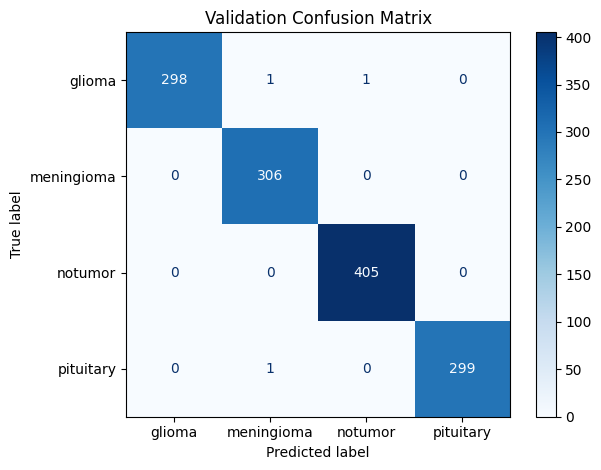


Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      1.00       300
  meningioma       0.99      1.00      1.00       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

# Collect predictions and labels together in the same loop
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    y_pred.extend(predicted_classes)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()

# Also print classification report for more metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
#from google.colab import files
#files.download("brain_tumor_efficientnet1.keras")

### **Trying with monitor metric being val_loss**

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Starting training...
=== Fine-tuning entire model ===
Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 91s 107ms/step - accuracy: 0.8210 - loss: 0.5393 - val_accuracy: 0.9413 - val_loss: 0.1808 - learning_rate: 0.0010
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9247 - loss: 0.2249 - val_accuracy: 0.9825 - val_loss: 0.0647 - learning_rate: 0.0010
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9563 - loss: 0.1291 - val_accuracy: 0.9756 - val_loss: 0.0908 - learning_rate: 0.0010
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.9655 - loss: 0.0959 - val_accuracy: 0.9825 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.9765 - loss: 0.0768 - val_accuracy: 0.9649 - val_loss: 0.1009 - learning_rate: 0.0010
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.9754 - loss: 0.0839 - val_accuracy: 0.9847 - 

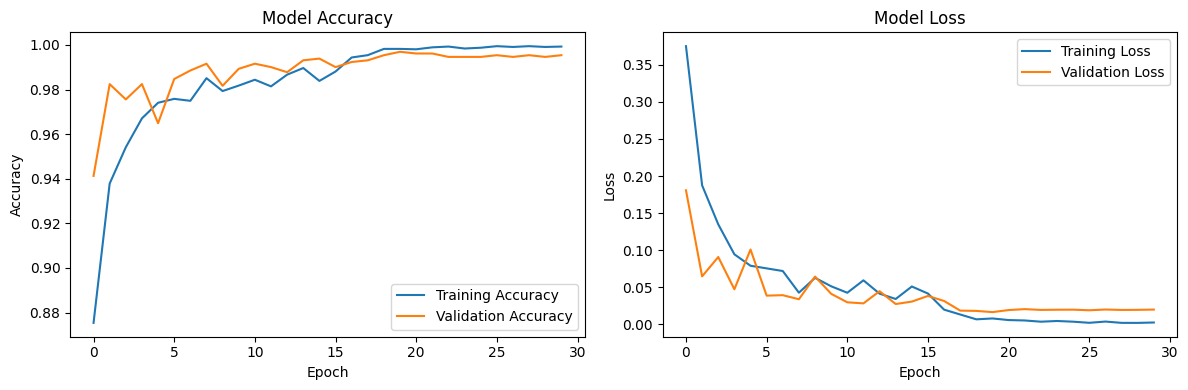


=== Making Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


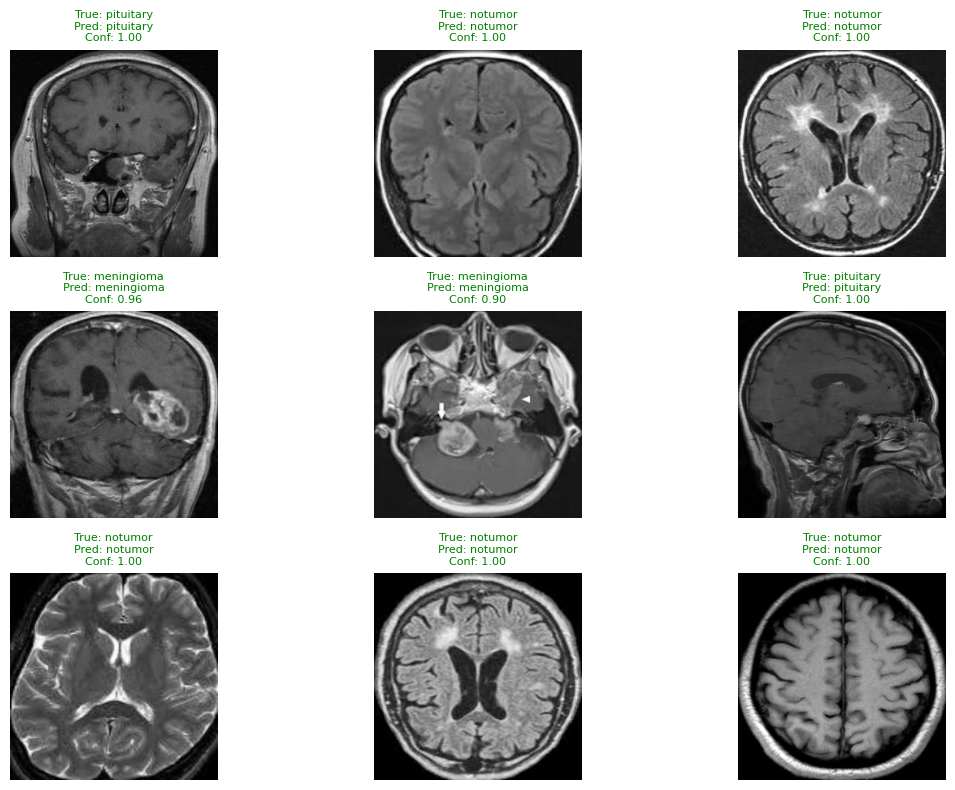

Model saved as 'brain_tumor_efficientnet_val_loss.keras'

Final Training Accuracy: 0.9982
Final Validation Accuracy: 0.9969


In [ ]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

if __name__ == "__main__":

    print("Class names:", class_names)

    # Train the model
    print("Starting training...")
    model_val_loss, history_val_loss = train_with_finetuning(train_ds, val_ds, num_classes=4, epochs=50, monitor_metric='val_loss')

    # Plot training history
    plot_training_history(history_val_loss)

    # Evaluate and show predictions
    evaluate_model(model_val_loss, val_ds, class_names)

    # Save the model
    model_val_loss.save('brain_tumor_efficientnet_val_loss.keras')
    print("Model saved as 'brain_tumor_efficientnet_val_loss.keras'")

    # Print final metrics
    best_val_acc_idx = np.argmin(history_val_loss['val_loss'])
    final_train_acc_val_loss = history_val_loss['accuracy'][best_val_acc_idx]
    final_val_acc_val_loss = history_val_loss['val_accuracy'][best_val_acc_idx]
    print(f"\nFinal Training Accuracy: {final_train_acc_val_loss:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc_val_loss:.4f}")


Final Training Accuracy: 0.9982
Final Validation Accuracy: 0.9969


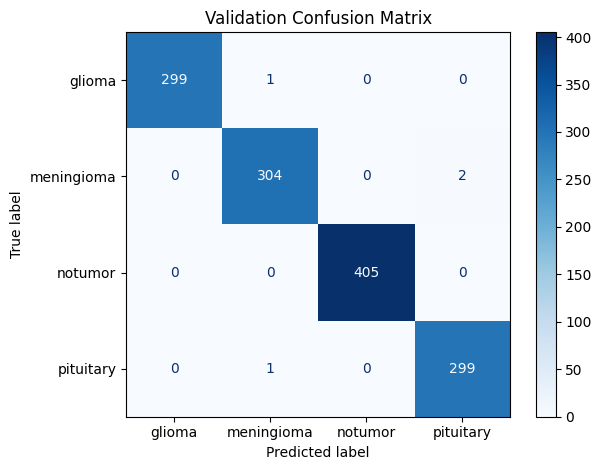


Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       300
  meningioma       0.99      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [ ]:
print(f"\nFinal Training Accuracy: {final_train_acc_val_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc_val_loss:.4f}")

# Collect predictions and labels together in the same loop
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model_val_loss.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    y_pred.extend(predicted_classes)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()

# Also print classification report for more metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

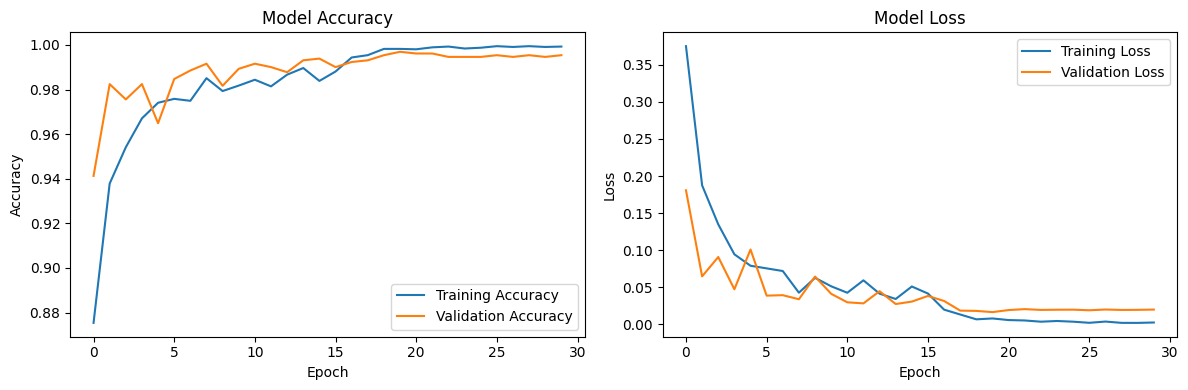

In [ ]:
# Plot training history
plot_training_history(history_val_loss)


=== Making Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


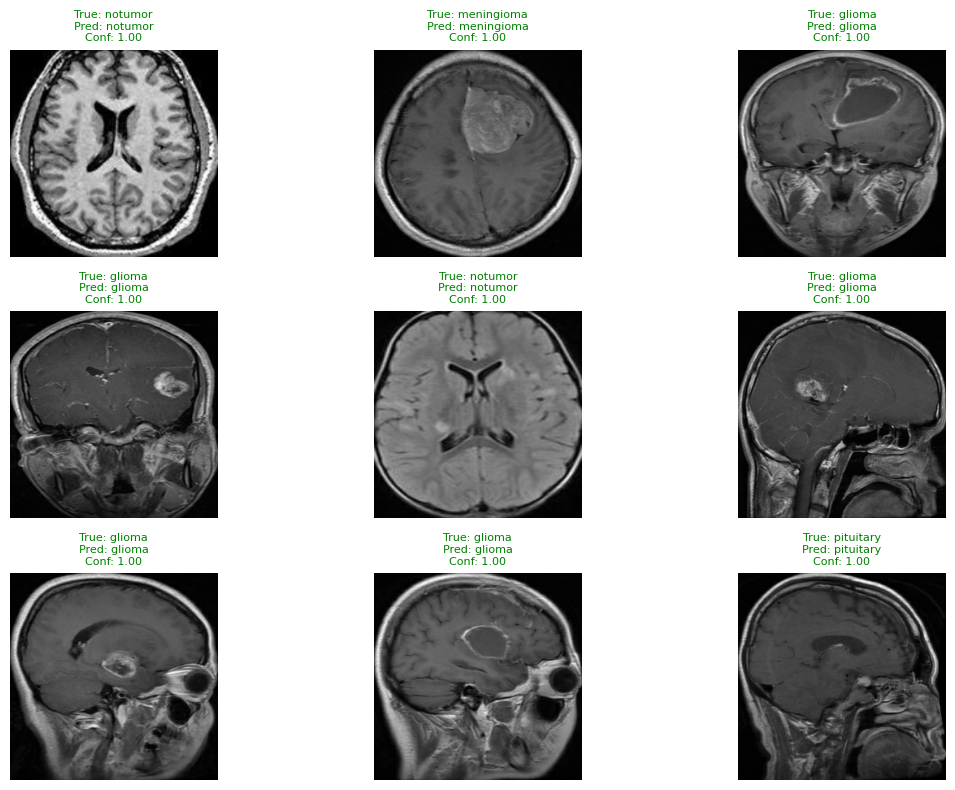

In [ ]:
# Evaluate and show predictions
evaluate_model(model_val_loss, val_ds, class_names)

In [ ]:
#from google.colab import files
#files.download("brain_tumor_efficientnet_val_loss.keras")

Trying One more Dense Layer

In [ ]:
# Create the EfficientNet model
def create_efficientnet_model(num_classes=4, input_shape=(256, 256, 3)):
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Add custom classification head
    inputs = tf.keras.Input(shape=input_shape)


    x = base_model(inputs)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Add dropout for regularization
    x = layers.Dropout(0.4)(x)

    # Additional dense layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.Dropout(0.2)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model, base_model

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Starting training...
=== Fine-tuning entire model ===
Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - accuracy: 0.7648 - loss: 0.6359 - val_accuracy: 0.9535 - val_loss: 0.1509 - learning_rate: 0.0010
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.9243 - loss: 0.2414 - val_accuracy: 0.9672 - val_loss: 0.0885 - learning_rate: 0.0010
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.9502 - loss: 0.1667 - val_accuracy: 0.9863 - val_loss: 0.0596 - learning_rate: 0.0010
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.9632 - loss: 0.1095 - val_accuracy: 0.9794 - val_loss: 0.0598 - learning_rate: 0.0010
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.9590 - loss: 0.1283 - val_accuracy: 0.9634 - val_loss: 0.1142 - learning_rate: 0.0010
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.9637 - loss: 0.1161 - val_accuracy: 0.9870 - 

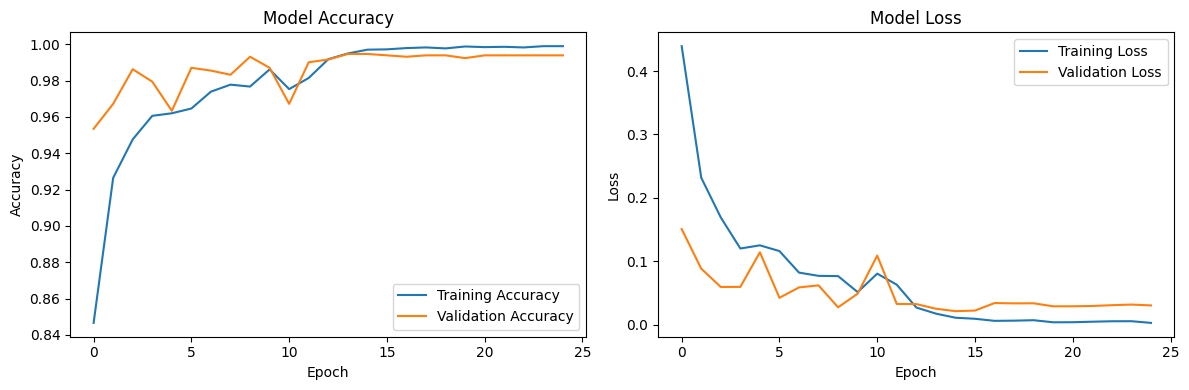


=== Making Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


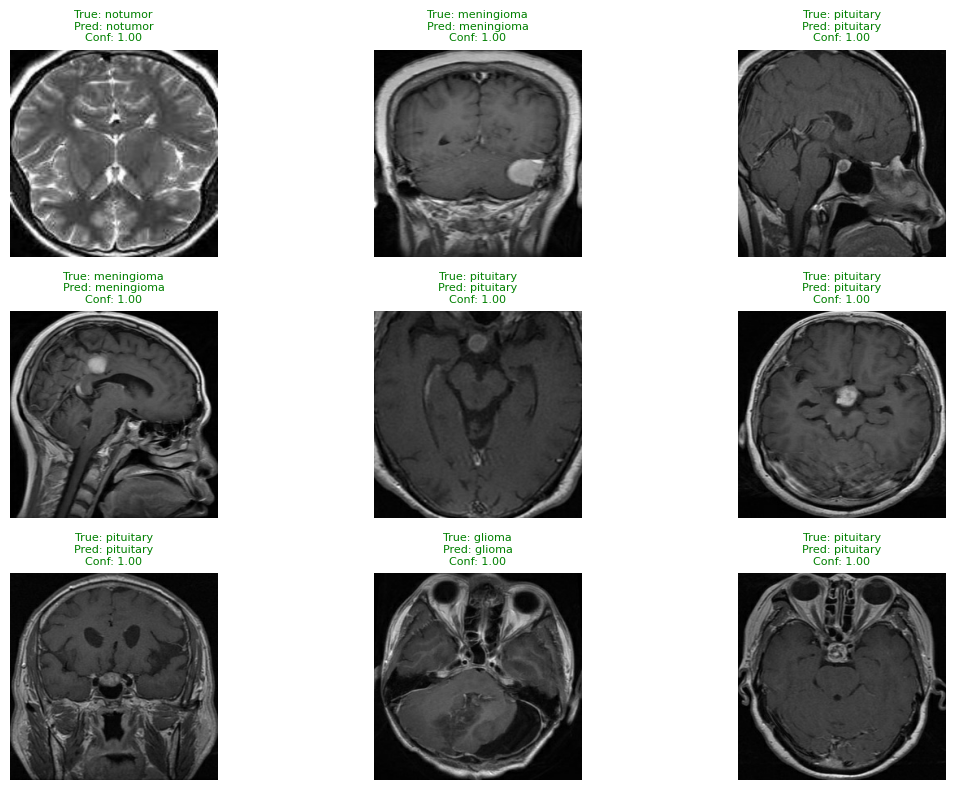

Model saved as 'brain_tumor_efficientnet_xtra_dense.keras'

Final Training Accuracy: 0.9949
Final Validation Accuracy: 0.9947


In [ ]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

if __name__ == "__main__":
    print("Class names:", class_names)

    # Train the model
    print("Starting training...")
    model_xtra_dense, history_xtra_dense = train_with_finetuning(train_ds, val_ds, num_classes=4, epochs=50, monitor_metric='val_loss')

    # Plot training history
    plot_training_history(history_xtra_dense)

    # Evaluate and show predictions
    evaluate_model(model_xtra_dense, val_ds, class_names)

    # Save the model
    #model_xtra_dense.save('brain_tumor_efficientnet_xtra_dense.keras')
    print("Model saved as 'brain_tumor_efficientnet_xtra_dense.keras'")

    # Print final metrics
    best_xtra_dense_idx = np.argmax(history_xtra_dense['val_accuracy'])
    final_train_xtra_dense = history_xtra_dense['accuracy'][best_xtra_dense_idx]
    final_val_xtra_dense = history_xtra_dense['val_accuracy'][best_xtra_dense_idx]
    print(f"\nFinal Training Accuracy: {final_train_xtra_dense:.4f}")
    print(f"Final Validation Accuracy: {final_val_xtra_dense:.4f}")

Trying Flattened Output instead of GlobalAveragePooling2D

In [ ]:
# Create the EfficientNet model
def create_efficientnet_model(num_classes=4, input_shape=(256, 256, 3)):
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Add custom classification head
    inputs = tf.keras.Input(shape=input_shape)


    x = base_model(inputs)

    # Flatten
    x = layers.Flatten()(x)

    # Add dropout for regularization
    x = layers.Dropout(0.2)(x)

    # Additional dense layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model, base_model

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Starting training...
=== Fine-tuning entire model ===
Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 108ms/step - accuracy: 0.8363 - loss: 0.5618 - val_accuracy: 0.9657 - val_loss: 0.1136 - learning_rate: 0.0010
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.9384 - loss: 0.1760 - val_accuracy: 0.9809 - val_loss: 0.0725 - learning_rate: 0.0010
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9650 - loss: 0.1115 - val_accuracy: 0.9809 - val_loss: 0.0585 - learning_rate: 0.0010
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9694 - loss: 0.0906 - val_accuracy: 0.9886 - val_loss: 0.0550 - learning_rate: 0.0010
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9791 - loss: 0.0667 - val_accuracy: 0.9908 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9726 - loss: 0.0831 - val_accuracy: 0.9878 - 

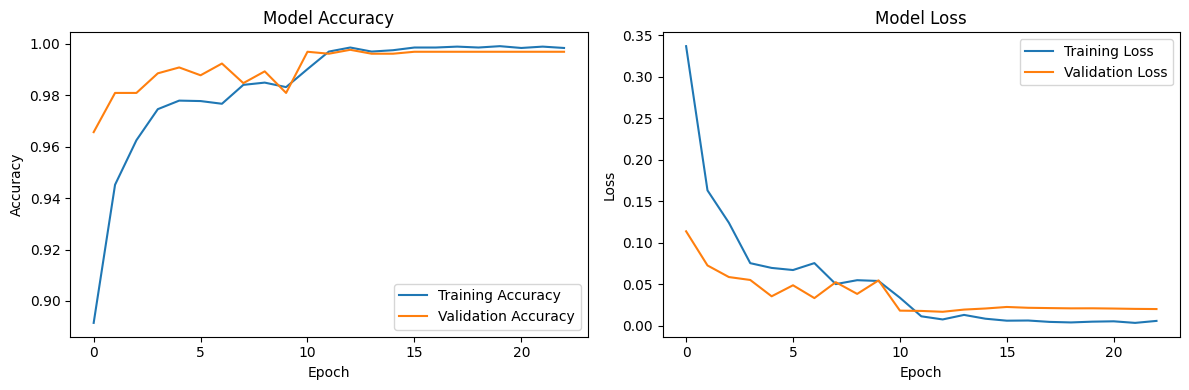


=== Making Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


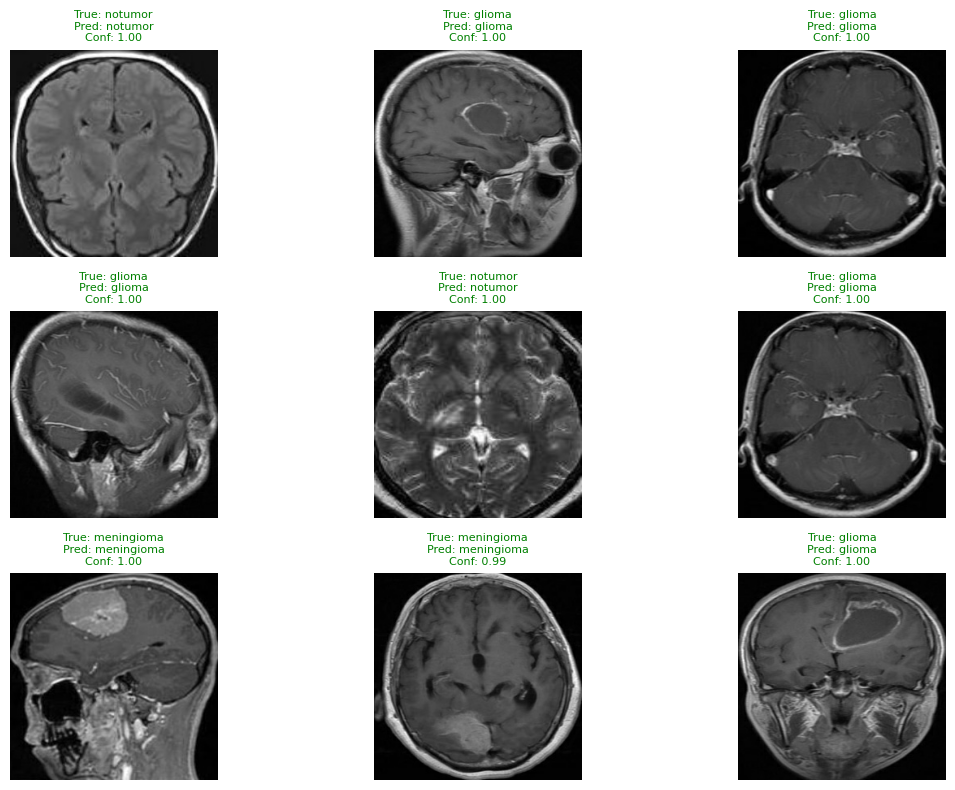

Model saved as 'brain_tumor_efficientnet_flatten.keras'

Final Training Accuracy: 0.9986
Final Validation Accuracy: 0.9977


In [ ]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

if __name__ == "__main__":
    # Use your existing datasets
    print("Class names:", class_names)

    # Train the model
    print("Starting training...")
    model_flatten, history_flatten = train_with_finetuning(train_ds, val_ds, num_classes=4, epochs=50, monitor_metric='val_loss')

    # Plot training history
    plot_training_history(history_flatten)

    # Evaluate and show predictions
    evaluate_model(model_flatten, val_ds, class_names)

    # Save the model
    #model_flatten.save('brain_tumor_efficientnet_flatten.keras')
    print("Model saved as 'brain_tumor_efficientnet_flatten.keras'")

    # Print final metrics
    best_flatten_idx = np.argmax(history_flatten['val_accuracy'])
    final_train_flatten = history_flatten['accuracy'][best_flatten_idx]
    final_val_flatten = history_flatten['val_accuracy'][best_flatten_idx]
    print(f"\nFinal Training Accuracy: {final_train_flatten:.4f}")
    print(f"Final Validation Accuracy: {final_val_flatten:.4f}")

Trying when all layers in EfficientNet model are unfreezed

In [ ]:
def create_efficientnet_model(num_classes=4, input_shape=(256, 256, 3)):
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Add custom classification head
    inputs = tf.keras.Input(shape=input_shape)


    x = base_model(inputs)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Add dropout for regularization
    x = layers.Dropout(0.2)(x)

    # Additional dense layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model, base_model

def train_with_finetuning(train_ds, val_ds, num_classes=4, epochs=20, monitor_metric = 'val_accuracy'):
    # Create preprocessing functions
    preprocess_train, preprocess_val = create_data_pipeline()

    # Apply preprocessing to datasets
    train_ds_processed = train_ds.map(preprocess_train,
                                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_processed = val_ds.map(preprocess_val,
                                 num_parallel_calls=tf.data.AUTOTUNE)

    # Prefetch for performance
    train_ds_processed = train_ds_processed.prefetch(tf.data.AUTOTUNE)
    val_ds_processed = val_ds_processed.prefetch(tf.data.AUTOTUNE)

    # Create model
    model, base_model = create_efficientnet_model(num_classes)
    #model = compile_model(model, learning_rate=0.001)

    # Callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor=monitor_metric,
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor=monitor_metric,
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
    ]

    #print("=== Phase 1: Training with frozen base model ===")
    # First: train only the classification head
    #history1 = model.fit(
    #    train_ds_processed,
     #   epochs=min(10, epochs//2),  # First phase - shorter
    #    validation_data=val_ds_processed,
    #    callbacks=callbacks,
   #     verbose=1
   # )

    print("=== Fine-tuning entire model ===")


    # Fine-tune from this layer onwards
    fine_tune_at = len(base_model.layers) // 2

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Continue training
    history = model.fit(
        train_ds_processed,
        epochs=epochs,
        #initial_epoch=len(history1.epoch),
        validation_data=val_ds_processed,
        callbacks=callbacks,
        verbose=1
    )

    # Combine histories
    total_history = {}
    for key in history.history.keys():
        total_history[key] = history.history[key]

    return model, total_history

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Starting training...
=== Fine-tuning entire model ===
Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 107ms/step - accuracy: 0.8054 - loss: 0.5770 - val_accuracy: 0.9527 - val_loss: 0.1248 - learning_rate: 5.0000e-04
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9384 - loss: 0.1702 - val_accuracy: 0.9771 - val_loss: 0.0930 - learning_rate: 5.0000e-04
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.9609 - loss: 0.1152 - val_accuracy: 0.9832 - val_loss: 0.0461 - learning_rate: 5.0000e-04
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9703 - loss: 0.0873 - val_accuracy: 0.9886 - val_loss: 0.0374 - learning_rate: 5.0000e-04
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9824 - loss: 0.0581 - val_accuracy: 0.9908 - val_loss: 0.0323 - learning_rate: 5.0000e-04
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.9807 - loss: 0.0604 - val

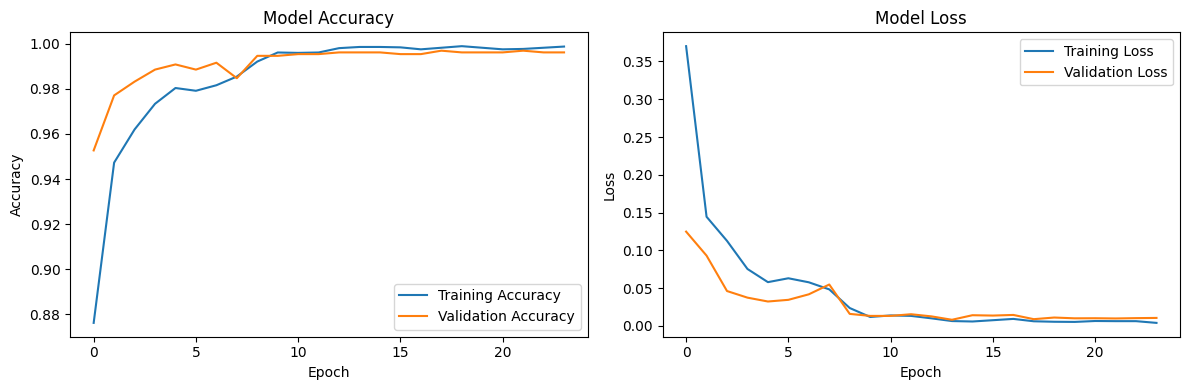


=== Making Predictions ===


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


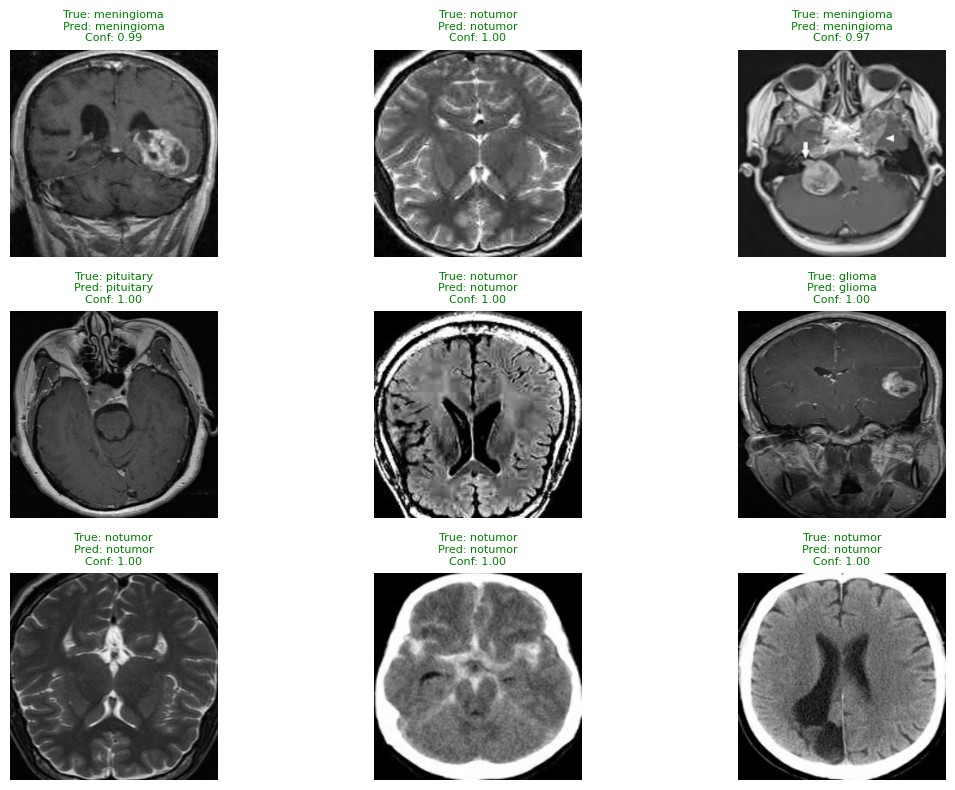

Model saved as 'brain_tumor_efficientnet_trainall.keras'

Final Training Accuracy: 0.9986
Final Validation Accuracy: 0.9962


In [ ]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

if __name__ == "__main__":
    # Use your existing datasets
    print("Class names:", class_names)

    # Train the model
    print("Starting training...")
    model_trainall, history_trainall = train_with_finetuning(train_ds, val_ds, num_classes=4, epochs=50, monitor_metric='val_loss')

    # Plot training history
    plot_training_history(history_trainall)

    # Evaluate and show predictions
    evaluate_model(model_trainall, val_ds, class_names)

    # Save the model
    #model_trainall.save('brain_tumor_efficientnet_trainall.keras')
    print("Model saved as 'brain_tumor_efficientnet_trainall.keras'")

    # Print final metrics
    best_trainall_idx = np.argmin(history_trainall['val_loss'])
    final_train_trainall = history_trainall['accuracy'][best_trainall_idx]
    final_val_trainall = history_trainall['val_accuracy'][best_trainall_idx]
    print(f"\nFinal Training Accuracy: {final_train_trainall:.4f}")
    print(f"Final Validation Accuracy: {final_val_trainall:.4f}")

In [ ]:
# Print final metrics
best_trainall_idx = np.argmin(history_trainall['val_loss'])
final_train_trainall = history_trainall['accuracy'][best_trainall_idx]
final_val_trainall = history_trainall['val_accuracy'][best_trainall_idx]
print(f"\nFinal Training Accuracy: {final_train_trainall:.4f}")
print(f"Final Validation Accuracy: {final_val_trainall:.4f}")


Final Training Accuracy: 0.9986
Final Validation Accuracy: 0.9962


In [ ]:
from keras.models import load_model
final_model = load_model('brain_tumor_efficientnet_val_loss.keras')

In [ ]:
final_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,819,222 (64.16 MB)

 Trainable params: 5,367,456 (20.48 MB)

 Non-trainable params: 716,852 (2.73 MB)

 Optimizer params: 10,734,914 (40.95 MB)

# Grad-CAM

In [ ]:
# Finding last CNN layer
last_cnn_layer = None

# getting efficientnet layer from model
effnet_build = final_model.get_layer('efficientnetv2-b0')
# finding last convolution layer in efficientnet model
for layer in reversed(effnet_build.layers):
  if isinstance(layer, tf.keras.layers.Conv2D):
    print(f"Last CNN layer: {layer.name}")
    last_cnn_layer = layer.name
    break

print(last_cnn_layer)

Last CNN layer: top_conv
top_conv


In [ ]:
from tensorflow.keras.models import clone_model
import matplotlib as mpl
def GradCAM(img_path, model, last_conv_layer_name, pred_index = None,
            cam_path = 'cam.jpg', alpha = 0.4, size = (256,256)):
  def get_img_array(img_path, size=size):
    # gets image from file
    img = keras.utils.load_img(img_path, target_size=size)
    # converts to array
    array = keras.utils.img_to_array(img)
    # Add a dimension to the batch (ie (256,256,3) to (1,256,256,3))
    array = np.expand_dims(array, axis=0)
    return array

  def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Simpler approach using submodel extraction
    """
    # Get EfficientNet
    effnet_model = model.get_layer('efficientnetv2-b0')
    last_conv_layer = effnet_model.get_layer(last_conv_layer_name)

    # Create new model: input -> last conv output
    last_conv_model = keras.Model(effnet_model.input, last_conv_layer.output)

    # Create classifier model: last conv output -> predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    # Get all layers after the last conv layer in effnet
    start_processing = False
    for layer in effnet_model.layers:
        if start_processing:
            x = layer(x)
        if layer.name == last_conv_layer_name:
            start_processing = True

    # Add remaining model layers
    for layer in model.layers[2:]:
        x = layer(x)

    classifier_model = keras.Model(classifier_input, x)

    # Compute gradients
    with tf.GradientTape() as tape:
        last_conv_output = last_conv_model(img_array)
        tape.watch(last_conv_output)
        preds = classifier_model(last_conv_output)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

  ## Testing
  img_array = keras.applications.efficientnet.preprocess_input(get_img_array(img_path))
  model_heatmap = clone_model(model)
  model_heatmap.set_weights(model.get_weights())

  # removing softmax layer
  model_heatmap.layers[-1].activation = None

  # Adding custom decoding function
  def decode_predictions(preds):
    classes = ['glioma' , 'meningioma' , 'notumor' , 'pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction


  # getting predictions
  grad_cam_preds = model_heatmap.predict(img_array)
  print("Predicted:", decode_predictions(grad_cam_preds))

  predicted_label = decode_predictions(grad_cam_preds)

  heatmap = make_gradcam_heatmap(img_array, model_heatmap, last_cnn_layer)

  def save_and_display_gradcam(img_path, heatmap, predicted_label = predicted_label,
                               cam_path = cam_path, alpha = alpha):
    # load original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Grabs label from file name
    actual_label = img_path.split('/')[-2]

    # Rescale heatmap to range 0-255
    heatmap = np.uint8(255*heatmap)

    # get colormap
    jet = mpl.colormaps["jet"]

    # use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    fig, ax = plt.subplots(figsize=(10, 8))

    # Display Grad CAM
    ax.imshow(superimposed_img)
    ax.axis('off')

    # Add title
    if predicted_label:
        title = f"Actual: {actual_label.capitalize()} | Predicted: {predicted_label.capitalize()}"
        color = 'green' if actual_label == predicted_label else 'red'
        ax.set_title(title, fontsize=14, pad=10, color=color)
    else:
        ax.set_title(f"Actual Label: {actual_label.capitalize()}", fontsize=14, pad=10)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Activation Intensity', rotation=270, labelpad=20, fontsize=12)

    plt.show()
  save_and_display_gradcam(img_path, heatmap)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted: meningioma


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_7']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


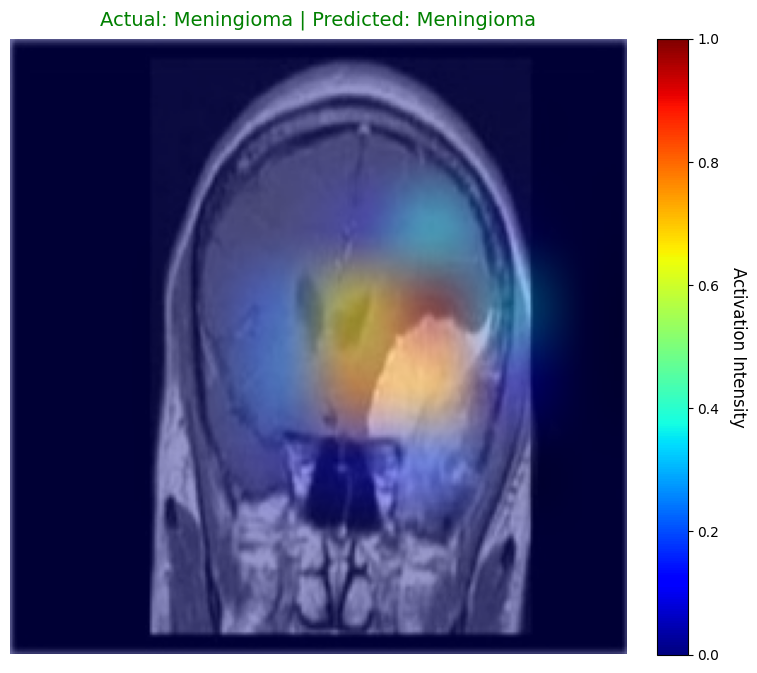

In [ ]:
img_path = 'cleaned/Testing/meningioma/Te-meTr_0000.jpg'

GradCAM(img_path, model = final_model, last_conv_layer_name=last_cnn_layer, alpha = 0.7,
        cam_path = 'meningoma_grad-cam.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted: notumor


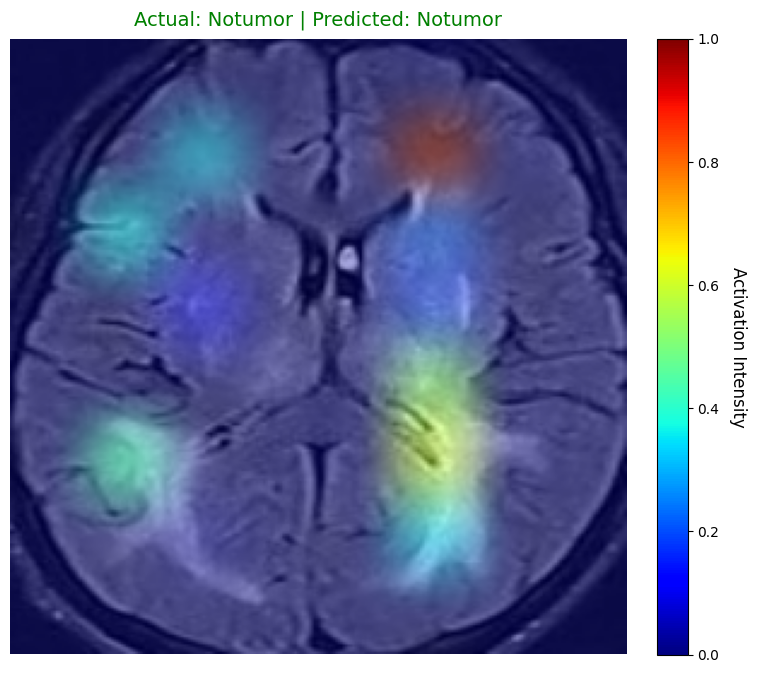

In [ ]:
img_path_notumor = 'cleaned/Testing/notumor/Te-noTr_0001.jpg'

GradCAM(img_path_notumor, model = final_model, last_conv_layer_name=last_cnn_layer, alpha = 0.7,
        cam_path = 'notumor_grad-cam.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted: pituitary


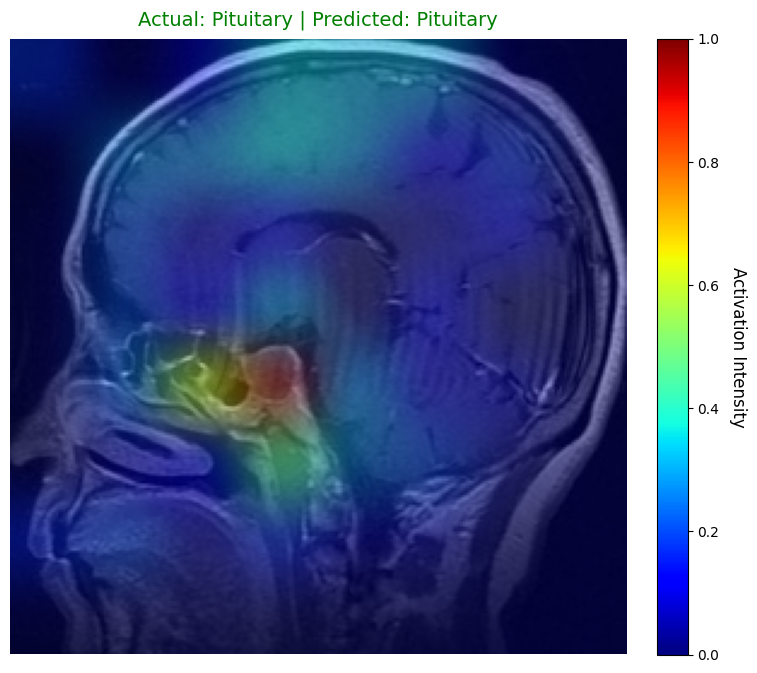

In [ ]:
img_path_pituitary = 'cleaned/Testing/pituitary/Te-piTr_0007.jpg'

GradCAM(img_path_pituitary, model = final_model, last_conv_layer_name=last_cnn_layer, alpha = 0.7,
        cam_path = 'pituitary_grad-cam.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted: glioma


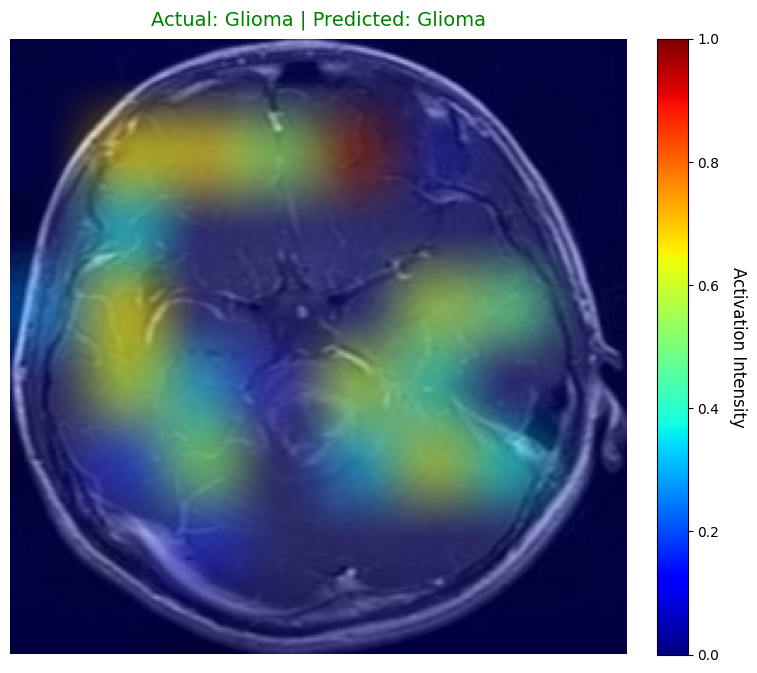

In [ ]:
img_path_glioma = 'cleaned/Testing/glioma/Te-glTr_0007.jpg'

GradCAM(img_path_glioma, model = final_model, last_conv_layer_name=last_cnn_layer, alpha = 0.7,
        cam_path = 'glioma_grad-cam.jpg')